<a href="https://colab.research.google.com/github/martintmv-git/RB-IBDM/blob/main/InsectSAM/InsectSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InsectSAM

In this notebook, we'll fine-tune `segment-anything` on a dataset of insect images and their corresponding masks for the RB-IBDM project.

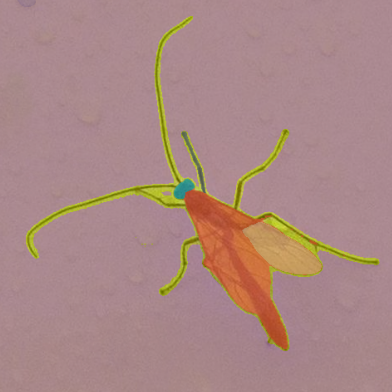

Resources used to create this notebook (thanks):

#### [Segment Anything](https://segment-anything.com/)
#### [Finetune SAM Blog](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
#### [MedSAM repository](https://github.com/bowang-lab/MedSAM)
#### [HF Forum](https://discuss.huggingface.co/)

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00


We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [3]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00


## Load dataset

See [this guide](https://huggingface.co/docs/datasets/image_dataset) from Hugging Face.

In [4]:
from datasets import load_dataset

dataset = load_dataset("martintmv/rb-ibdm", split="train")

Generating train split:   0%|          | 0/733 [00:00<?, ? examples/s]

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 733
})

We can visualize an example:

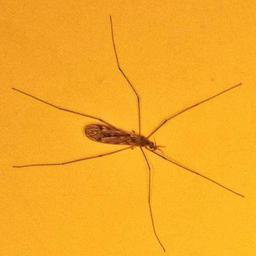

In [6]:
example = dataset[0]
image = example["image"]
image

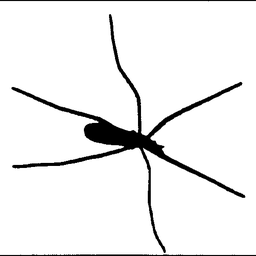

In [7]:
example = dataset[0]
label = example["label"]
label

(-0.5, 255.5, 255.5, -0.5)

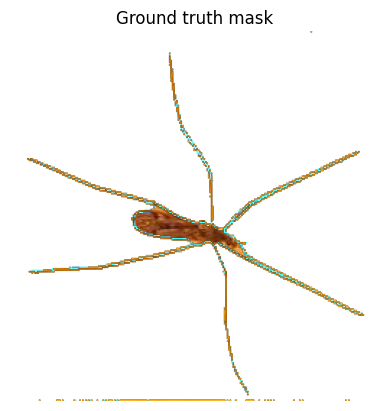

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [9]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [10]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [11]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [12]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [13]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [16]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Load the model

In [17]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

## Train the model

In [18]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [20]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# num_epochs = 100
num_epochs = 10 # for testing

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 367/367 [02:07<00:00,  2.89it/s]


EPOCH: 0
Mean loss: -803201670.452316


100%|██████████| 367/367 [02:07<00:00,  2.88it/s]


EPOCH: 1
Mean loss: -968788503.0190736


100%|██████████| 367/367 [02:08<00:00,  2.87it/s]


EPOCH: 2
Mean loss: -1156944481.3079019


100%|██████████| 367/367 [02:06<00:00,  2.89it/s]


EPOCH: 3
Mean loss: -1369249994.1144414


100%|██████████| 367/367 [02:07<00:00,  2.89it/s]


EPOCH: 4
Mean loss: -1608556532.1416893


100%|██████████| 367/367 [02:07<00:00,  2.89it/s]


EPOCH: 5
Mean loss: -1876618988.8174386


100%|██████████| 367/367 [02:07<00:00,  2.89it/s]


EPOCH: 6
Mean loss: -2175011024.915531


100%|██████████| 367/367 [02:06<00:00,  2.89it/s]


EPOCH: 7
Mean loss: -2506481047.7166214


100%|██████████| 367/367 [02:07<00:00,  2.88it/s]


EPOCH: 8
Mean loss: -2873160524.730245


100%|██████████| 367/367 [02:07<00:00,  2.88it/s]

EPOCH: 9
Mean loss: -3276900098.7901907


In [21]:
import os
from google.colab import drive

drive.mount('/content/drive')

# save the model
model_save_path = '/content/drive/MyDrive/diopsis_tests/InsectSAM.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Mounted at /content/drive
Model saved to /content/drive/MyDrive/diopsis_tests/InsectSAM.pth


## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

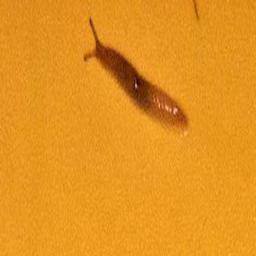

In [22]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 4

# load image
image = dataset[idx]["image"]
image

In [23]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [24]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [25]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

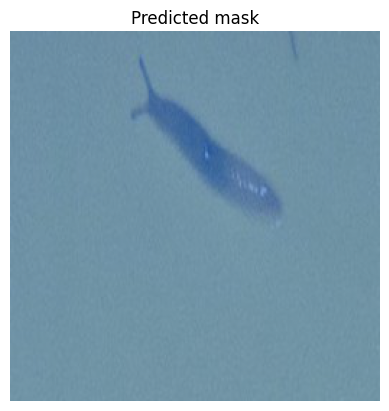

In [26]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 255.5, 255.5, -0.5)

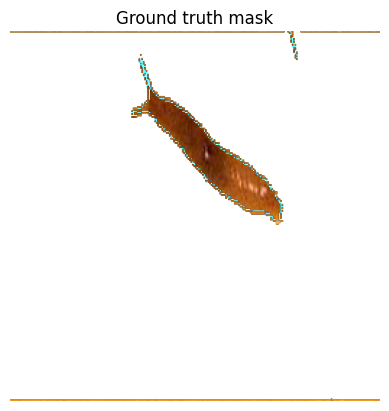

In [27]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# TO DO:
#### 1. Understand what causes the `mean loss` to be huge and fail the training.
***Potential issues***

*   Check if the dataset causes the training issue.

Make sure the masks are read correctly as 2D arrays with binary values.
Normalize them to have a range of 0.0 to 1.0 if they're not already in this range. Ensure that these tensors are passed correctly to your loss function. Masks must be Grayscale, Images must be RGB.

---
*   Check the outputs of the model to see if they contain any unexpected values like NaNs or infinities.
*    Evaluate the loss on a single batch outside the training loop to see if it returns a reasonable value.
*    Print the shapes of predicted_masks and ground_truth_masks right before the loss calculation to ensure they are as expected.
*    Try running the loss function with some dummy data (e.g., create some random tensors that mimic the expected shapes and values) to see if it behaves normally.


#### 2. Re-run the notebook after resolving the problem and get the trained InsectSAM model.